In [2]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from Engine import Engine
from matplotlib import pyplot as plt
import xgboost

In [3]:
import numpy as np
import pandas as pd
from time import time
from Node import Node

In [4]:
from scipy.stats import norm

# BStackGP

In [5]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [6]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

In [7]:
def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

In [8]:
def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p

In [9]:
def train(X,y,total_size,elite_size,bins,epochs):
    E = Engine(Functions.simple_opset,X,y)
    for i in range(epochs):
        E.evolve(total_size=total_size,batch_size=total_size,
                                        elite_size=elite_size,bins=bins,beta=[0,0,0],verbose=0)
        
    return E
    

In [10]:
def gradient(E,log_odds,p,residual):
    vals = E.best[3]
    (table,width,val_max,val_min,bins) = E.best[2]

    index = ((vals - val_min)//width).astype('int32')
    index = np.where(index >= bins,bins-1,index)
    index = np.where(index < 0,0,index)

    residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(bins)])
    p_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(bins)])
    grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    grads = np.zeros(log_odds.shape)
    for i in range(bins):
        grads[index==i] = grad_bin[i]
        
    return grads,E.best[1],E.best[2],grad_bin

In [11]:
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 100,out=np.zeros(log_odds_1.shape)+100)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 1e5,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

In [12]:
def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for param in stack:
        node,node_param,grad_bin = param
        
        vals = node.predict(X)
        (table,width,val_max,val_min,bins) = node_param

        index = ((vals - val_min)//width).astype('int32')
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)
        
        grads = np.zeros(log_odds.shape)
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [13]:
def evolve(X_train,X_test,y_train,y_test,total_size,elite_size,bins,learning_rate):
    train_acc = []
    test_acc = []
    train_bacc = []
    test_bacc = []

    stack = []

    y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
    X = X_train
    y = y_train

    init_log_odds,init_p = initial(y_train_one_hot)

    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for i in range(3000):
        residual = y_train_one_hot - p
        E = train(X,y,total_size,elite_size,bins)
        grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
        
        loss = np.sum(np.power(residual,2))
        if not np.isnan(loss):
            # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
            # X = X[pure_index == False]
            # y = y[pure_index == False]
            # y_train_one_hot = y_train_one_hot[pure_index == False]
            # log_odds = log_odds[pure_index == False]
            # p = p[pure_index == False]
            
            
            stack.append((node,node_param,grad_bin))
            
            # pred = predict(X_train,init_log_odds,init_p,stack)
            pred = np.argmax(p,axis=1)
            train_acc.append(accuracy_score(y_train,pred))
            train_bacc.append(balanced_accuracy_score(y_train,pred))
            
            # pred = predict(X_test,init_log_odds,init_p,stack)
            # pred = np.argmax(pred,axis=1)
            # test_acc.append(accuracy_score(y_test,pred))
            # test_bacc.append(balanced_accuracy_score(y_test,pred))
            
            print(train_acc[-1],train_bacc[-1])
            # print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
        
        else:
            break
        print(loss,y.shape)

    pred = predict(X_train,init_log_odds,init_p,stack)
    pred = np.argmax(pred,axis=1)
    print(classification_report(y_train,pred))

    pred = predict(X_test,init_log_odds,init_p,stack)
    pred = np.argmax(pred,axis=1)
    print(classification_report(y_test,pred))
    
    return stack,(init_log_odds,init_p,learning_rate)


# Shuttle

In [28]:
train_df = pd.read_csv('../data/shuttle.trn',header=None,delimiter=' ')
test_df = pd.read_csv('../data/shuttle.tst',header=None,delimiter=' ')

X_train = train_df.iloc[:,:-1].to_numpy()
y_train = train_df.iloc[:,-1].to_numpy()

X_test = test_df.iloc[:,:-1].to_numpy()
y_test = test_df.iloc[:,-1].to_numpy()

In [29]:
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

In [65]:
pred = predict(X_train,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     34108
           1       0.97      0.95      0.96        37
           2       0.93      0.92      0.92       132
           3       1.00      0.74      0.85      6748
           4       1.00      1.00      1.00      2458
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00        11

    accuracy                           0.96     43500
   macro avg       0.98      0.94      0.96     43500
weighted avg       0.96      0.96      0.96     43500

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     11478
           1       1.00      0.92      0.96        13
           2       0.95      0.90      0.92        39
           3       1.00      0.75      0.86      2155
           4       1.00      1.00      1.00       809
           5       1.00      0.50      0.67         4
           6       1.00 

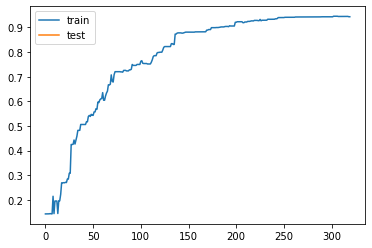

In [66]:
plt.plot(train_bacc)
plt.plot(test_bacc)
plt.legend(["train","test"])

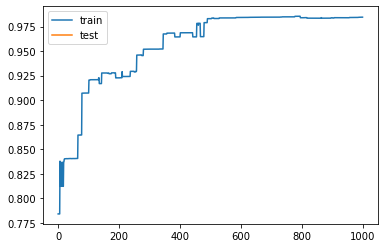

In [59]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

# Yeast

In [110]:
X = []
y = []
with open('../data/yeast.data','r') as f:
    for line in f:
        item = line.split()
        X.append(item[1:-1])
        y.append(item[-1])
X = np.array(X,dtype=float)

In [111]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [117]:
train_acc = []
test_acc = []
train_bacc = []
test_bacc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
X = X_train
y = y_train

init_log_odds,init_p = initial(y_train_one_hot)

log_odds,p = initial_first_bin(init_log_odds,init_p,X)

for i in range(3000):
    residual = y_train_one_hot - p
    E = train(X,y)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p)
    
    loss = np.sum(np.power(residual,2))
    if not np.isnan(loss):
        # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
        # X = X[pure_index == False]
        # y = y[pure_index == False]
        # y_train_one_hot = y_train_one_hot[pure_index == False]
        # log_odds = log_odds[pure_index == False]
        # p = p[pure_index == False]
        
        
        stack.append((node,node_param,grad_bin))
        
        # pred = predict(X_train,init_log_odds,init_p,stack)
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        train_bacc.append(balanced_accuracy_score(y_train,pred))
        
        pred = predict(X_test,init_log_odds,init_p,stack)
        pred = np.argmax(pred,axis=1)
        test_acc.append(accuracy_score(y_test,pred))
        test_bacc.append(balanced_accuracy_score(y_test,pred))
        
        # print(train_acc[-1],train_bacc[-1])
        print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
    
    else:
        break
    print(loss,y.shape)

pred = predict(X_train,init_log_odds,init_p,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))


0.36608863198458574 0.2562138608612091 : 0.32062780269058294 0.1280651398876065
2751.777270072281 (1038,)
0.37957610789980734 0.3013226213936985 : 0.3295964125560538 0.24949371131617792
1750.4063479871597 (1038,)
0.37764932562620424 0.311681660784996 : 0.34977578475336324 0.369603601426068
1270.9577015558993 (1038,)
0.3786127167630058 0.3005172223408522 : 0.35874439461883406 0.3496810040949997
1026.4325347889132 (1038,)
0.3805394990366089 0.3089209409359322 : 0.3475336322869955 0.29265143340555755
887.853380271225 (1038,)
0.394990366088632 0.3670906490047211 : 0.35874439461883406 0.3803437410978652
816.6005445611468 (1038,)
0.3930635838150289 0.36303870850116776 : 0.3609865470852018 0.3802978168728365
777.705150615474 (1038,)
0.4653179190751445 0.4433542623299161 : 0.4798206278026906 0.4670821800506423
756.6109005881285 (1038,)
0.4662813102119461 0.43916339868329457 : 0.47757847533632286 0.46643118307522774
722.2106307764716 (1038,)
0.4527938342967245 0.4293399106386976 : 0.45067264573

KeyboardInterrupt: 

In [120]:
pred = predict(X_train,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       330
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        31
           4       1.00      0.95      0.97        37
           5       0.91      0.92      0.92       102
           6       0.83      0.76      0.80       179
           7       0.77      0.72      0.74       295
           8       1.00      1.00      1.00        15
           9       1.00      0.59      0.74        22

    accuracy                           0.80      1038
   macro avg       0.92      0.87      0.89      1038
weighted avg       0.80      0.80      0.80      1038

              precision    recall  f1-score   support

           0       0.53      0.65      0.59       133
           1       0.00      0.00      0.00         1
           2       0.50      0.50      0.50        12
           3       0.65 

/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

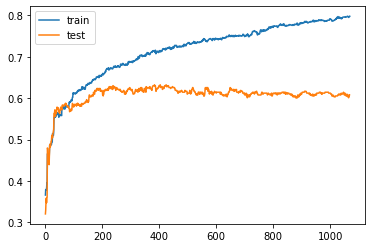

In [123]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

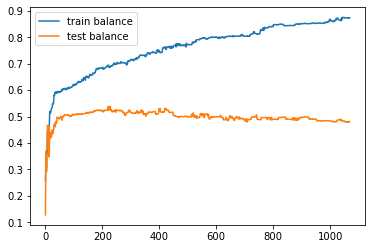

In [124]:
plt.plot(train_bacc)
plt.plot(test_bacc)
plt.legend(["train balance","test balance"])

# covertype

In [129]:
df = pd.read_csv('../data/covtype.data',header=None)

In [136]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

In [138]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [155]:
train_acc = []
test_acc = []
train_bacc = []
test_bacc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
X = X_train
y = y_train

init_log_odds,init_p = initial(y_train_one_hot)

log_odds,p = initial_first_bin(init_log_odds,init_p,X)

for i in range(3000):
    residual = y_train_one_hot - p
    E = train(X,y)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p)
    
    loss = np.sum(np.power(residual,2))
    if not np.isnan(loss):
        # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
        # X = X[pure_index == False]
        # y = y[pure_index == False]
        # y_train_one_hot = y_train_one_hot[pure_index == False]
        # log_odds = log_odds[pure_index == False]
        # p = p[pure_index == False]
        
        
        stack.append((node,node_param,grad_bin))
        
        # pred = predict(X_train,init_log_odds,init_p,stack)
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        train_bacc.append(balanced_accuracy_score(y_train,pred))
        
        # pred = predict(X_test,init_log_odds,init_p,stack)
        # pred = np.argmax(pred,axis=1)
        # test_acc.append(accuracy_score(y_test,pred))
        # test_bacc.append(balanced_accuracy_score(y_test,pred))
        
        print(train_acc[-1],train_bacc[-1])
        # print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
    
    else:
        break
    print(loss,y.shape)

pred = predict(X_train,init_log_odds,init_p,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))


0.6723619894371392 0.31959651764540115
745908.3043520793 (406708,)
0.6729545521602722 0.298665050716908
462505.58031160163 (406708,)
0.6774540948297059 0.3247381963378199
340615.81882655 (406708,)
0.6806972078247785 0.3162686740432508
264753.30286419886 (406708,)
0.6811717497565821 0.30986128828114984
232001.23514077356 (406708,)
0.6837214906025945 0.3276547171119922
214545.64629503782 (406708,)
0.686782654877701 0.3303923228745375
197018.8920254395 (406708,)
0.6937876805963984 0.3333357003947217
187708.52564922246 (406708,)
0.6960104054997689 0.33312374613043344
182374.43358342105 (406708,)
0.6955604512328255 0.33126633430266705
179229.49898604897 (406708,)
0.6958505856781769 0.34519294569711156
177887.86060889918 (406708,)
0.6956661781917248 0.3535448810144693
173785.33790335845 (406708,)
0.7018647285030046 0.3566848170071583
171760.7394307071 (406708,)
0.7022064970445627 0.3646210143696112
169112.34386762264 (406708,)
0.7016262281538598 0.3689643950486828
167680.24395591635 (406708,

KeyboardInterrupt: 

In [153]:
pred = predict(X_train,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78    148228
           1       0.80      0.85      0.82    198359
           2       0.89      0.88      0.88     24997
           3       1.00      0.99      0.99      1870
           4       0.99      0.28      0.44      6694
           5       0.91      0.68      0.78     12106
           6       0.92      0.74      0.82     14454

    accuracy                           0.81    406708
   macro avg       0.90      0.74      0.79    406708
weighted avg       0.81      0.81      0.80    406708

              precision    recall  f1-score   support

           0       0.72      0.71      0.72     63612
           1       0.75      0.82      0.78     84942
           2       0.72      0.74      0.73     10757
           3       0.83      0.34      0.48       877
           4       0.71      0.07      0.13      2799
           5       0.64      0.38      0.47      5261
           6       0.78 

In [157]:
pred = predict(X_train,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack[:-1])
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    148228
           1       0.82      0.87      0.85    198359
           2       0.93      0.91      0.92     24997
           3       1.00      1.00      1.00      1870
           4       0.99      0.46      0.63      6694
           5       0.95      0.81      0.87     12106
           6       0.98      0.80      0.88     14454

    accuracy                           0.84    406708
   macro avg       0.93      0.81      0.85    406708
weighted avg       0.84      0.84      0.83    406708

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     63612
           1       0.75      0.82      0.79     84942
           2       0.71      0.74      0.72     10757
           3       0.82      0.28      0.42       877
           4       0.76      0.13      0.22      2799
           5       0.63      0.39      0.49      5261
           6       0.83 

In [158]:
from sklearn.metrics import confusion_matrix

In [159]:
confusion_matrix(y_test,pred)

array([[46021, 16961,    17,     0,    25,    19,   569],
       [13914, 69737,   808,     1,    82,   331,    69],
       [    2,  2008,  7951,    32,     3,   761,     0],
       [    0,     0,   527,   249,     0,   101,     0],
       [   25,  2371,    39,     0,   359,     4,     1],
       [    1,  1256,  1901,    23,     3,  2077,     0],
       [ 2873,    59,     0,     0,     0,     0,  3124]])

In [167]:
sum([s[0].numNode for s in stack]),np.average([s[0].depth for s in stack])

(538, 1.4411764705882353)

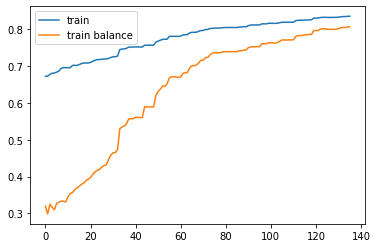

In [156]:
plt.plot(train_acc)
plt.plot(train_bacc)
plt.legend(["train","train balance"])

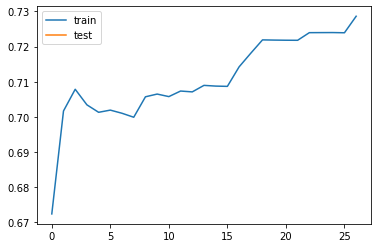

In [151]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

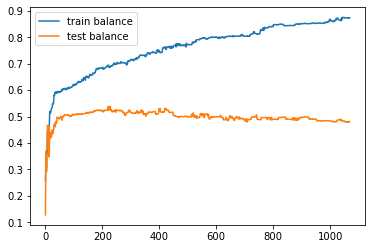

In [ ]:
plt.plot(train_bacc)
plt.plot(test_bacc)
plt.legend(["train balance","test balance"])

# connect 4

In [238]:
df = pd.read_csv("../data/connect-4.data",header=None)

In [244]:
df = df.replace('b',0)
df = df.replace('x',1)
df = df.replace('o',-1)

df = df.replace('win',1)
df = df.replace('draw',0)
df = df.replace('loss',-1)

X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

In [245]:
# for i in range(X.shape[1]): 
#     X[:,i] *= (i+1)

In [246]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [255]:
train_acc = []
test_acc = []
train_bacc = []
test_bacc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
X = X_train
y = y_train

init_log_odds,init_p = initial(y_train_one_hot)
total_size = 10
elite_size = 3
bins = 1000
learning_rate = 1
epochs = 30


log_odds,p = initial_first_bin(init_log_odds,init_p,X)
for i in range(10000):
    residual = y_train_one_hot - p
    E = train(X,y,total_size,elite_size,bins,epochs)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = np.sum(np.power(residual,2))
    if not np.isnan(loss):
        # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
        # X = X[pure_index == False]
        # y = y[pure_index == False]
        # y_train_one_hot = y_train_one_hot[pure_index == False]
        # log_odds = log_odds[pure_index == False]
        # p = p[pure_index == False]
        
        
        stack.append((node,node_param,grad_bin))
        
        # pred = predict(X_train,init_log_odds,init_p,stack)
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        train_bacc.append(balanced_accuracy_score(y_train,pred))
        
        pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
        pred = np.argmax(pred,axis=1)
        test_acc.append(accuracy_score(y_test,pred))
        # test_bacc.append(balanced_accuracy_score(y_test,pred))
        
        print(train_acc[-1],test_acc[-1])
        # print(train_acc[-1],train_bacc[-1])
        # print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
    
    else:
        break
    print(loss,y.shape)

pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

0.693353634037514 0.6836392342609039
36839.37256049146 (47289,)
0.69976104379454 0.6910400631537399
20753.257977272802 (47289,)
0.7198925754403772 0.7079632918886916
19684.028502804642 (47289,)
0.7315654803442662 0.7196072626800868
18445.559546691085 (47289,)
0.7399818139525048 0.7282909019143478
17628.626850981418 (47289,)
0.7435555837509781 0.7315966054864812
17129.1720632178 (47289,)
0.7568779208695469 0.7425004933885928
16903.77599563585 (47289,)
0.7578506629448709 0.7429938819814486
16019.587458754955 (47289,)
0.7631373046585886 0.7455101638050128
15887.693058370975 (47289,)
0.7755291928355431 0.75601934083284
15616.15422155424 (47289,)
0.7766499608788513 0.7556739688178409
14891.99633403718 (47289,)
0.7791875489014358 0.7576968620485495
14746.062331388799 (47289,)
0.7869060458034638 0.7610025656206828
14567.905529197498 (47289,)
0.7926367654211339 0.7616933096506808
14123.816661904562 (47289,)
0.7970352513269471 0.7639628971778173
13809.2018133367 (47289,)
0.806551206411639 0.772

/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8711539681532703 0.7792579435563449
9594.66301795231 (47289,)
0.870709890249318 0.7803927373199132
9783.063443487865 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8699486138425426 0.7774324057627787
9771.909756151075 (47289,)
0.8708790627841569 0.7793072824156305
9839.017536884934 (47289,)
0.870223519211656 0.7776791000592066
9782.879197717304 (47289,)
0.8617014527691429 0.7712157094927965
9881.59762119263 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8612362282983358 0.7701795934477995
10304.726713100044 (47289,)
0.8596925289179301 0.7690941385435168
10385.121968615802 (47289,)
0.8572183805959103 0.7699822380106572
10573.246272835984 (47289,)
0.8553786292795365 0.7685514110913756
10740.338145830667 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8569223286599421 0.7700809157292283
10898.381150332048 (47289,)
0.8571126477616359 0.7711170317742254
10991.893583436464 (47289,)
0.8571760874622005 0.7700809157292283
11005.607722385348 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8553997758463914 0.7708703374777975
11023.31679445569 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8543847406373575 0.7710676929149398
11116.919966483025 (47289,)
0.8547230857070355 0.7742253799092165
11196.665906015078 (47289,)
0.8537503436317114 0.7718571146635089
11168.192924962486 (47289,)
0.8505783586034807 0.7670712453128083
11310.172288149051 (47289,)
0.8514876609782401 0.7694395105585159
11760.153217771482 (47289,)
0.8464759246336357 0.7677126504835208
11691.337878955395 (47289,)
0.8433039396054051 0.7636668640221038
11945.873794706013 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8423734906637907 0.7629761199921058
12311.173835135502 (47289,)
0.8419505593266933 0.7656897572528123
12313.013812101184 (47289,)
0.8401742477108841 0.7638642194592461
12316.023550491798 (47289,)
0.8409143775508047 0.7648509966449576
12422.075313166379 (47289,)
0.8396878766732221 0.7649003355042432
12327.308520766492 (47289,)
0.8434308190065343 0.7688474442470891
12377.534754800059 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8250755989765062 0.7561180185514111
12211.57871818747 (47289,)
0.8294106451817548 0.7611999210578252
13688.216963676841 (47289,)
0.8299816024868363 0.7622360371028222
13412.637515783612 (47289,)
0.8303833872570788 0.7642095914742452
13263.846701253626 (47289,)
0.8270210831271543 0.7601638050128281
13249.765612466383 (47289,)
0.8292837657806256 0.7616933096506808
13463.04929578497 (47289,)
0.8050709467317981 0.7386520623643181
13320.938692888754 (47289,)
0.8191122671234325 0.7522202486678508
14910.147064896282 (47289,)
0.8202753283004505 0.7529109926978488
13997.747326696737 (47289,)
0.8105690541140645 0.7434872705743043
13892.640683539425 (47289,)
0.8181818181818182 0.7519242155121374
14479.539703425537 (47289,)
0.8217555879802914 0.7533057035721334
14052.638738955808 (47289,)
0.8233415804944068 0.7561180185514111
13851.906294768296 (47289,)
0.8239759775000529 0.7551805802249852
13743.678615015297 (47289,)
0.8140793842119732 0.7451647917900138
13709.026163228991 (47289,)
0.8183086975

/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8198946900970627 0.751381488059996
14954.74826247354 (47289,)
0.8199369832307725 0.7504933885928557
15106.099428733982 (47289,)
0.8209097253060965 0.7530590092757056
15170.179481106536 (47289,)
0.820994311573516 0.7547858693507006
15250.164307429823 (47289,)
0.8214383894774683 0.7566114071442668
15242.883561099145 (47289,)
0.8227494766224703 0.7559206631142688
15193.982384745745 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8224111315527924 0.7516281823564239
15072.264901365123 (47289,)
0.8221785193173888 0.7532070258535623
15233.247364225746 (47289,)
0.8231724079595678 0.7527629761199921
15304.79131944541 (47289,)
0.8239125377994883 0.7525162818235642
15305.11940410181 (47289,)
0.823299287360697 0.7526149595421354
15350.847558944877 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.821988200215695 0.7514308269192816
15437.857900237654 (47289,)
0.8204233542684345 0.7510361160449971
15546.919292057672 (47289,)
0.8177377402778659 0.7488652062364318
15611.965056465813 (47289,)
0.816722705068832 0.7473850404578646
15833.096857860779 (47289,)
0.8160671614963311 0.7465462798500099
15961.041099226397 (47289,)
0.8132335215377784 0.7447700809157293
16010.121557313 (47289,)
0.813783332276005 0.7458555358200119
16366.047469485995 (47289,)
0.812303072596164 0.7466449575685811
16451.756032611225 (47289,)
0.811647529023663 0.7453621472271561
16560.672453664985 (47289,)
0.8092156738353529 0.7440299980264456
16770.91461829363 (47289,)
0.8095963120387405 0.74398065916716
16855.620014036856 (47289,)
0.8083275180274483 0.7452141306492994
16909.663805321277 (47289,)
0.8066780858127683 0.7424511545293073
16971.322598913735 (47289,)
0.8058322231385735 0.7429938819814486
17147.014524168273 (47289,)
0.8058533697054283 0.7430925597000198
17162.020670131416 (47289,)
0.8047326016621201 0.

/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.8011165387299372 0.7381586737714624
17569.60932387409 (47289,)
0.8009050730613885 0.7369745411486086
17753.81605813611 (47289,)
0.7993613736809829 0.736579830274324
17879.267739011448 (47289,)
0.798198312503965 0.7344089204657588
18025.032115614285 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.7967814925246887 0.7336688375764753
18226.422986462752 (47289,)
0.7940324388335553 0.7322873495164792
18393.782270837815 (47289,)
0.7947091289729112 0.7320406552200514
18616.54543547673 (47289,)
0.7943496373363784 0.7319419775014802
18663.01514821808 (47289,)
0.792615618854279 0.7333234655614762
18740.72742196541 (47289,)
0.7896762460614519 0.732188671797908
18783.72447763922 (47289,)
0.7886400642855632 0.7296723899743438
19015.86211672886 (47289,)
0.7857218380595911 0.7289816459443458
19189.907321034738 (47289,)
0.7862716487978176 0.7294256956779159
19378.698042135555 (47289,)
0.7837763539089428 0.7300671008486284
19456.823197908852 (47289,)
0.7840301127112014 0.7310045391750543
19570.002513349562 (47289,)
0.7828881981010383 0.7309552003157687
19760.686270756236 (47289,)
0.7820846285605532 0.7293763568186303
19795.327813190324 (47289,)
0.7799065321745015 0.7281922241957766
19908.39791337737 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.7804563429127281 0.7284389184922044
19980.231366076667 (47289,)
0.779166402334581 0.7277481744622064
20094.178700267774 (47289,)
0.7784474190615154 0.7253799092164989
20177.56866409566 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.7801391444099051 0.727106769291494
20234.31853215626 (47289,)
0.7800545581424856 0.7282909019143478
20198.440745448555 (47289,)
0.7788492038317579 0.7289816459443458
20265.097474147766 (47289,)
0.7792721351688553 0.7286362739293467
20277.458129039118 (47289,)
0.7803717566453087 0.7290309848036314
20311.20202955478 (47289,)
0.7783628327940959 0.7279455298993487
20351.88094455672 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.7766288143119965 0.7273534635879219
20590.138576584017 (47289,)
0.7772420647507877 0.7270080915729228
20707.2295083526 (47289,)
0.7741546659899765 0.7243931320307875
20653.827935231177 (47289,)
0.7732030704815074 0.7232583382672193
20905.877751856104 (47289,)
0.7715536382668274 0.7221728833629366
21019.077253021584 (47289,)
0.7724206475078771 0.7236037102822183
21207.262483380804 (47289,)
0.7714690519994079 0.7239984211565028
21181.43202234062 (47289,)
0.7707712152931971 0.7232583382672193
21223.95561864255 (47289,)
0.7693332487470659 0.7225675942372213
21206.93157142441 (47289,)
0.7666476347564973 0.7195579238208013
21283.709612133367 (47289,)
0.7654211338789148 0.7210380895993684
21588.050588664286 (47289,)
0.7689526105436782 0.7229129662522202
21696.39408785154 (47289,)
0.7680221616020639 0.7228636273929346
21534.36803629605 (47289,)


/tmp/ipykernel_5315/343224810.py:11: RuntimeWarning: overflow encountered in true_divide
  grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))


0.7649559094081076 0.7208900730215118
21575.24522920272 (47289,)
0.7639197276322189 0.7180777580422341
21705.45668319988 (47289,)
0.7635602359956861 0.7184231300572331
21869.378517396744 (47289,)
0.7616358984118928 0.7167456088415236
21923.30494323192 (47289,)
0.7616358984118928 0.7174363528715216
22023.316784045506 (47289,)
0.7609380617056821 0.7157588316558121
22046.21434393523 (47289,)
0.7584639133836621 0.7128478389579633
22053.310748492757 (47289,)
0.7567933346021274 0.7102328794158279
22389.2275443058 (47289,)
0.7579563957791453 0.7114663508979673
22422.39213692605 (47289,)


KeyboardInterrupt: 

In [233]:
pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11688
           1       0.99      0.96      0.98      4518
           2       0.99      1.00      1.00     31083

    accuracy                           0.99     47289
   macro avg       0.99      0.98      0.99     47289
weighted avg       0.99      0.99      0.99     47289

              precision    recall  f1-score   support

           0       0.70      0.65      0.68      4947
           1       0.33      0.21      0.26      1931
           2       0.84      0.90      0.87     13390

    accuracy                           0.78     20268
   macro avg       0.62      0.59      0.60     20268
weighted avg       0.76      0.78      0.76     20268



# Madelon

In [184]:
train_df = pd.read_csv("../data/madelon_train.data",header=None,delimiter=' ')
train_label = pd.read_csv("../data/madelon_train.labels",header=None,delimiter=' ')
test_df = pd.read_csv("../data/madelon_valid.data",header=None,delimiter=' ')
test_label = pd.read_csv("../data/madelon_valid.labels",header=None,delimiter=' ')

In [189]:
X_train = train_df.to_numpy()[:,:-1]
train_label = train_label.replace(-1,0)
y_train = train_label.to_numpy().flatten()

X_test = test_df.to_numpy()[:,:-1]
test_label = test_label.replace(-1,0)
y_test = test_label.to_numpy().flatten()

In [190]:
X = np.concatenate([X_train,X_test])
y = np.concatenate([y_train,y_test])

In [191]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [198]:
train_acc = []
test_acc = []
train_bacc = []
test_bacc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
X = X_train
y = y_train

init_log_odds,init_p = initial(y_train_one_hot)
total_size = 100
elite_size = 30
bins = 10
learning_rate = 1
epochs = 100


log_odds,p = initial_first_bin(init_log_odds,init_p,X)
for i in range(3000):
    residual = y_train_one_hot - p
    E = train(X,y,total_size,elite_size,bins,epochs)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = np.sum(np.power(residual,2))
    if not np.isnan(loss):
        # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
        # X = X[pure_index == False]
        # y = y[pure_index == False]
        # y_train_one_hot = y_train_one_hot[pure_index == False]
        # log_odds = log_odds[pure_index == False]
        # p = p[pure_index == False]
        
        
        stack.append((node,node_param,grad_bin))
        
        # pred = predict(X_train,init_log_odds,init_p,stack)
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        # train_bacc.append(balanced_accuracy_score(y_train,pred))
        
        pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
        pred = np.argmax(pred,axis=1)
        test_acc.append(accuracy_score(y_test,pred))
        # test_bacc.append(balanced_accuracy_score(y_test,pred))
        
        print(train_acc[-1],test_acc[-1])
        # print(train_acc[-1],train_bacc[-1])
        # print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
    
    else:
        break
    print(loss,y.shape)

pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

0.6208144796380091 0.6
1171.2774841383164 (2210,)
0.6457013574660634 0.6512820512820513
1004.0928365447526 (2210,)
0.6579185520361991 0.6512820512820513
980.5063790889074 (2210,)
0.6692307692307692 0.6461538461538462
973.3604649792933 (2210,)
0.6656108597285068 0.6512820512820513
965.0698384048591 (2210,)
0.6660633484162896 0.658974358974359
957.903690423935 (2210,)
0.6628959276018099 0.658974358974359
945.4762303967948 (2210,)
0.6665158371040724 0.6615384615384615
938.0784614599091 (2210,)
0.669683257918552 0.6666666666666666
934.1223250200592 (2210,)
0.6705882352941176 0.6615384615384615
926.5494075351238 (2210,)
0.6705882352941176 0.6743589743589744
924.4522008931933 (2210,)
0.6819004524886878 0.6717948717948717
919.2120673858533 (2210,)
0.6742081447963801 0.676923076923077
912.7550721084449 (2210,)
0.6751131221719457 0.6820512820512821
910.7365662454631 (2210,)
0.676923076923077 0.6743589743589744
909.9654486862769 (2210,)
0.6723981900452489 0.6846153846153846
908.7847438235185 (22

KeyboardInterrupt: 

In [161]:
pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.83      0.83      0.83      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       300
           1       0.67      0.67      0.67       300

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600



# Sleep

In [23]:
df = pd.read_csv('../data/sleep.tsv',delimiter='\t')

In [25]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [54]:
train_acc = []
test_acc = []
train_bacc = []
test_bacc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
X = X_train
y = y_train

init_log_odds,init_p = initial(y_train_one_hot)
total_size = 30
elite_size = 10
bins = 250
learning_rate = 0.5
epochs = 20


log_odds,p = initial_first_bin(init_log_odds,init_p,X)
for i in range(100):
    residual = y_train_one_hot - p
    E = train(X,y,total_size,elite_size,bins,epochs)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = np.sum(np.power(residual,2))
    if not np.isnan(loss):
        # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
        # X = X[pure_index == False]
        # y = y[pure_index == False]
        # y_train_one_hot = y_train_one_hot[pure_index == False]
        # log_odds = log_odds[pure_index == False]
        # p = p[pure_index == False]
        
        
        stack.append((node,node_param,grad_bin))
        
        # pred = predict(X_train,init_log_odds,init_p,stack)
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        # train_bacc.append(balanced_accuracy_score(y_train,pred))
        
        pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
        pred = np.argmax(pred,axis=1)
        test_acc.append(accuracy_score(y_test,pred))
        # test_bacc.append(balanced_accuracy_score(y_test,pred))
        
        print(train_acc[-1],test_acc[-1])
        # print(train_acc[-1],train_bacc[-1])
        # print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
    
    else:
        break
    print(loss,y.shape)

pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

0.6500303500370945 0.6491675321814119
100821.05144706885 (74135,)
0.6722600660956364 0.6706952443898908
54044.40561855465 (74135,)
0.6716935320698725 0.6671702388820697
40823.7399610348 (74135,)
0.6807310986713428 0.6777767286689957
36832.591986945496 (74135,)
0.6878532407095165 0.6853617851635037
34594.743949278236 (74135,)
0.6987118095366561 0.6943001919869071
33239.58124983793 (74135,)
0.70317663721589 0.6990526547697731
32210.20170969161 (74135,)
0.7056181290888245 0.7004689516255941
31634.06966799851 (74135,)
0.7085317326498954 0.7023888206968181
31320.959196156982 (74135,)
0.7105955351723208 0.7038995373430271
31000.18249337929 (74135,)
0.714048694948405 0.7073301230604602
30728.515358706107 (74135,)
0.7203884804748095 0.7098479841374752
30168.310906653634 (74135,)
0.7235718621433871 0.7130582570106694
29703.17630085084 (74135,)


KeyboardInterrupt: 

In [39]:
pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=5))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=5))

              precision    recall  f1-score   support

           0    0.74863   0.78686   0.76727     14981
           1    0.43094   0.08574   0.14303      6368
           2    0.75734   0.90174   0.82325     36829
           3    0.77659   0.70407   0.73856      7539
           4    0.77486   0.59242   0.67147      8418

    accuracy                        0.75321     74135
   macro avg    0.69767   0.61417   0.62872     74135
weighted avg    0.73149   0.75321   0.72766     74135

              precision    recall  f1-score   support

           0    0.73008   0.78285   0.75554      6378
           1    0.39489   0.07489   0.12590      2684
           2    0.75202   0.89092   0.81560     15869
           3    0.75495   0.68296   0.71716      3293
           4    0.75964   0.56636   0.64891      3549

    accuracy                        0.74249     31773
   macro avg    0.67832   0.59960   0.61262     31773
weighted avg    0.71860   0.74249   0.71646     31773



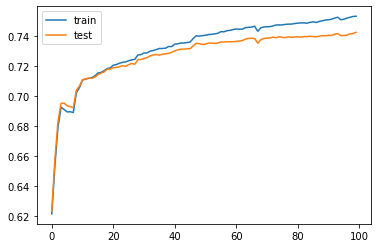

In [42]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

# kddcup

In [14]:
df = pd.read_csv('../data/kddcup.tsv',delimiter='\t')

In [15]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [26]:
train_acc = []
test_acc = []
train_bacc = []
test_bacc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
X = X_train
y = y_train

init_log_odds,init_p = initial(y_train_one_hot)
total_size = 30
elite_size = 10
bins = 2000
learning_rate = 0.5
epochs = 3


log_odds,p = initial_first_bin(init_log_odds,init_p,X)
for i in range(100):
    residual = y_train_one_hot - p
    E = train(X,y,total_size,elite_size,bins,epochs)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = np.sum(np.power(residual,2))
    if not np.isnan(loss):
        # pure_index = np.array(np.any(p > 0.99999,axis=1).T)[0]
        # X = X[pure_index == False]
        # y = y[pure_index == False]
        # y_train_one_hot = y_train_one_hot[pure_index == False]
        # log_odds = log_odds[pure_index == False]
        # p = p[pure_index == False]
        
        
        stack.append((node,node_param,grad_bin))
        
        # pred = predict(X_train,init_log_odds,init_p,stack)
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        # train_bacc.append(balanced_accuracy_score(y_train,pred))
        
        pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
        pred = np.argmax(pred,axis=1)
        test_acc.append(accuracy_score(y_test,pred))
        # test_bacc.append(balanced_accuracy_score(y_test,pred))
        
        print(train_acc[-1],test_acc[-1])
        # print(train_acc[-1],train_bacc[-1])
        # print(train_acc[-1],train_bacc[-1],':',test_acc[-1],test_bacc[-1])
    
    else:
        break
    print(loss,y.shape)

pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred))

0.8948885817231228 0.8946601352171977
2012782.452243388 (345814,)
0.9849687982557097 0.9843596075732427
619053.3936308521 (345814,)
0.9900061882977554 0.9894943524553662
216359.65346997484 (345814,)
0.9911397456436118 0.9905671835148374
80219.30804394154 (345814,)
0.9917499002353867 0.9910462464407649
32243.11661321693 (345814,)
0.9912322809371512 0.9902500573526039
15203.556783385531 (345814,)
0.9921547421446211 0.9914106041590759
9082.703471588398 (345814,)
0.9924496983927776 0.9913701199681524
6466.7590293150215 (345814,)
0.9938492947075596 0.9926521193473948
5579.802008215409 (345814,)
0.9939823141920223 0.9928680350323199
4307.0417989735915 (345814,)
0.9942425697051016 0.9928005613807808
3995.3470541345823 (345814,)
0.9948353739293377 0.9928208034762426
3711.4385342958367 (345814,)
0.9950580369794166 0.9934685505310177
3272.5208691122875 (345814,)
0.9949365844066463 0.9931581717339379
2997.4335654164543 (345814,)
0.9949799603254929 0.9933066137673239
2852.407361599992 (345814,)
0.

KeyboardInterrupt: 

In [34]:
from sklearn.metrics import confusion_matrix

In [40]:
"{:4}".format(1)

'   1'

In [48]:
def cm(y,p):
    m = confusion_matrix(y,p)
    for i in range(23):
        print("{:5}".format(i),end=" ")
    print()
    
    for i in m:
        for j in i:
            print("{:5}".format(j),end=" ")
        print()

In [49]:
cm(y_test,pred)

    0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22 
   61     0     0     0     0     0     0     0     0     0     0   609     0     0     0     0     0     0     0     0     0     0     0 
    0     4     0     0     0     0     0     0     0     0     0     3     0     0     0     0     0     0     0     0     0     2     0 
    0     2     0     0     0     0     0     0     0     0     0     1     0     0     0     0     0     0     0     0     0     0     0 
    0     0     0    15     0     0     0     0     0     0     0     1     0     0     0     0     0     0     0     1     0     0     0 
    0     0     0     0     3     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 
    0     0     0     0     0   366     0     0     0     9     5     4     0     0     0     0     0     0     0     0     0     0     0 
    0     0     0     0    

In [35]:
pred = predict(X_train,init_log_odds,init_p,learning_rate,stack[:10])
pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=5))
print(confusion_matrix(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack[:10])
pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=5))
print(confusion_matrix(y_test,pred))

/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0    0.88235   0.10763   0.19186      1533
           1    0.76471   0.61905   0.68421        21
           2    1.00000   0.40000   0.57143         5
           3    0.97297   1.00000   0.98630        36
           4    1.00000   1.00000   1.00000         9
           5    0.98932   0.96640   0.97773       863
           6    0.92308   0.85714   0.88889        14
           7    1.00000   0.40000   0.57143         5
           8    0.50000   0.40000   0.44444         5
           9    0.99899   0.99979   0.99939     75155
          10    0.92715   0.82353   0.87227       170
          11    0.97689   0.99561   0.98616     68137
          12    1.00000   1.00000   1.00000         2
          13    0.00000   0.00000   0.00000         2
          14    0.97740   0.93011   0.95317       186
          15    0.98748   0.95946   0.97327       740
          16    1.00000   0.33333   0.50000         9
          17    0.97467   0

/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

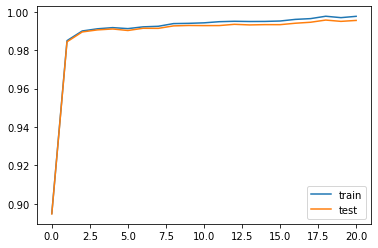

In [28]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

In [31]:
len(stack)

21

In [32]:
[ i[0] for i in stack]

[( _minus -> ( _minus -> |10| |32| ) |31| ),
 ( _add -> ( _minus -> ( _add -> |2| |30| ) |28| ) |33| ),
 ( _minus -> |36| ( _add -> |3| |2| ) ),
 ( _minus -> |28| ( _add -> |34| |2| ) ),
 ( _multiply -> |33| ( _add -> |31| ( _minus -> |36| |2| ) ) ),
 ( _add -> |10| ( _divide -> |32| ( _minus -> |25| |2| ) ) ),
 ( _add -> ( _add -> |33| |16| ) |3| ),
 ( _add -> ( _add -> |36| |32| ) |3| ),
 ( _add -> |2| ( _add -> |34| |26| ) ),
 ( _minus -> |2| ( _minus -> |16| |37| ) ),
 ( _multiply -> |32| |2| ),
 ( _divide -> ( _add -> ( _add -> |37| |33| ) |32| ) |22| ),
 ( _add -> |2| ( _minus -> |27| |37| ) ),
 ( _minus -> ( _minus -> ( _divide -> |3| |2| ) ( _add -> |38| |30| ) ) ( _minus -> |2| |11| ) ),
 ( _minus -> |34| |2| ),
 ( _add -> ( _divide -> ( _minus -> |17| |2| ) ( _divide -> |32| |3| ) ) |35| ),
 ( _add -> ( _add -> |33| |19| ) ( _divide -> ( _divide -> |3| |2| ) ( _minus -> |22| |3| ) ) ),
 ( _add -> |35| ( _divide -> |2| |23| ) ),
 ( _minus -> ( _add -> ( _add -> |33| |24| ) |2|